In [1]:
!pwd

/global/u2/k/kfrields/climsim-kaggle-edition/evaluation/offline


In [1]:
import numpy as np
from sklearn.metrics import r2_score
import torch
import os, gc
from climsim_utils.data_utils import *
from tqdm import tqdm
from matplotlib import cm

In [5]:
def apply_temperature_rules(T):
    # Create an output tensor, initialized to zero
    output = np.zeros_like(T)

    # Apply the linear transition within the range 253.16 to 273.16
    mask = (T >= 253.16) & (T <= 273.16)
    output[mask] = (T[mask] - 253.16) / 20.0  # 20.0 is the range (273.16 - 253.16)

    # Values where T > 273.16 set to 1
    output[T > 273.16] = 1

    # Values where T < 253.16 are already set to 0 by the initialization
    return output


def preprocessing_v2_rh_mc(data, input_path, target_path, input_sub, input_div, lbd_qn, out_scale):
    npy_input = np.load(input_path)
    npy_target = np.load(target_path)

    surface_pressure = npy_input[:, data.ps_index]
    
    hyam_component = (data.hyam * data.p0)[np.newaxis,:]
    hybm_component = data.hybm[np.newaxis,:] * surface_pressure[:, np.newaxis]
    
    pressures = hyam_component + hybm_component
    pressures = pressures.reshape(-1,384,60)
    
    pressures_binned = data.zonal_bin_weight_3d(pressures)
    
    actual_input = npy_input.copy().reshape(-1, data.num_latlon, data.input_feature_len)

    npy_input[:,120:180] = 1 - np.exp(-npy_input[:,120:180] * lbd_qn)
    npy_input = (npy_input - input_sub)/input_div
    npy_input = np.where(np.isnan(npy_input), 0, npy_input)
    npy_input = np.where(np.isinf(npy_input), 0, npy_input)
    npy_input[:,120:120+15] = 0
    npy_input[:,60:120] = np.clip(npy_input[:,60:120], 0, 1.2)
    torch_input = torch.tensor(npy_input).float()

    reshaped_target = npy_target.reshape(-1, data.num_latlon, data.target_feature_len)

    #print(reshaped_target.shape)
    t_before = actual_input[:, :, 0:60]
    qn_before = actual_input[:, :, 120:180]
    liq_frac_before = apply_temperature_rules(t_before)
    qc_before = liq_frac_before * qn_before
    qi_before = (1 - liq_frac_before) * qn_before

    t_new = t_before + reshaped_target[:, :, 0:60]*1200
    qn_new = qn_before + reshaped_target[:, :, 120:180]*1200
    liq_frac_new = apply_temperature_rules(t_new)
    qc_new = liq_frac_new * qn_new
    qi_new = (1 - liq_frac_new) * qn_new
    print(qc_new.shape)
    actual_target = np.concatenate((reshaped_target[:, :, 0:120], 
                                    (qc_new - qc_before)/1200, 
                                    (qi_new - qi_before)/1200, 
                                    reshaped_target[:, :, 180:240], 
                                    reshaped_target[:, :, 240:]), axis=2)
    return torch_input, actual_input, actual_target, pressures_binned


In [4]:
#input_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_input.npy'
#target_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_target.npy'

#============creates normalization metrics========
input_mean_v2_rh_mc_file = 'input_mean_v2_rh_mc_pervar.nc'
input_max_v2_rh_mc_file = 'input_max_v2_rh_mc_pervar.nc'
input_min_v2_rh_mc_file = 'input_min_v2_rh_mc_pervar.nc'
output_scale_v2_rh_mc_file = 'output_scale_std_lowerthred_v2_rh_mc.nc'
lbd_qn_file = 'qn_exp_lambda_large.txt'

grid_path = '../../grid_info/ClimSim_low-res_grid-info.nc'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_mean_v2_rh_mc_file)
input_max = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_max_v2_rh_mc_file)
input_min = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_min_v2_rh_mc_file)
output_scale = xr.open_dataset('../../preprocessing/normalizations/outputs/' + output_scale_v2_rh_mc_file)
lbd_qn = np.loadtxt('../../preprocessing/normalizations/inputs/' + lbd_qn_file, delimiter = ',')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale,
                  qinput_log = False,
                  normalize = False)
data.set_to_v2_rh_mc_vars()

input_sub_v2_rh_mc, input_div_v2_rh_mc, out_scale_v2_rh_mc = data.save_norm(write=False) # this extracts only the relevant variables
input_sub_v2_rh_mc = input_sub_v2_rh_mc[None, :]
input_div_v2_rh_mc = input_div_v2_rh_mc[None, :]
out_scale_v2_rh_mc = out_scale_v2_rh_mc[None, :]

In [6]:
#========create scoring data==========
v2_rh_mc_input_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_input.npy'
v2_rh_mc_target_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_target.npy'

#applies preprocessing to scoring data
torch_input_v2_rh_mc, actual_input_v2_rh_mc, actual_target, pressures_binned = preprocessing_v2_rh_mc(data = data, 
                                                                                                      input_path = v2_rh_mc_input_path, 
                                                                                                      target_path = v2_rh_mc_target_path, 
                                                                                                      input_sub = input_sub_v2_rh_mc, 
                                                                                                      input_div = input_div_v2_rh_mc, 
                                                                                                      lbd_qn = lbd_qn, 
                                                                                                      out_scale = out_scale_v2_rh_mc)


/tmp/ipykernel_298334/1028368508.py:33: RuntimeWarning: divide by zero encountered in divide
  npy_input = (npy_input - input_sub)/input_div


(4380, 384, 60)


In [11]:

#=======load model==========
standard_unet_path = '/pscratch/sd/k/kfrields/hugging/E3SM-MMF_saved_models/diffusion_models/diff_test/unet_model.pt'
standard_save_path = '/pscratch/sd/k/kfrields/hugging/E3SM-MMF_saved_models/diffusion_models/diff_test/offline'


In [8]:
def inference_model(data, model_path, actual_input, torch_input, out_scale):
    model = torch.jit.load(model_path).to(device)
    model.eval()
    batch_pred_list = []
    batch_size = data.num_latlon
    with torch.no_grad():
        for i in tqdm(range(0, torch_input.shape[0], batch_size)):
            batch = torch_input[i:i+batch_size].to(device)
            batch_pred = model(batch)
            batch_pred[:, 60:75] = 0
            batch_pred[:, 120:135] = 0
            batch_pred[:, 180:195] = 0
            batch_pred[:, 240:255] = 0
            batch_pred_list.append(batch_pred.cpu().numpy() / out_scale)
    model_preds = np.stack(batch_pred_list, axis=0)

    t_before = actual_input[:, :, 0:60]
    qn_before = actual_input[:, :, 120:180]
    liq_frac_before = apply_temperature_rules(t_before)
    qc_before = liq_frac_before * qn_before
    qi_before = (1 - liq_frac_before) * qn_before

    t_new = t_before + model_preds[:, :, 0:60]*1200
    qn_new = qn_before + model_preds[:, :, 120:180]*1200
    liq_frac_new = apply_temperature_rules(t_new)
    qc_new = liq_frac_new * qn_new
    qi_new = (1 - liq_frac_new) * qn_new
    
    actual_preds = np.concatenate((model_preds[:, :, 0:120], 
                                  (qc_new - qc_before)/1200, 
                                  (qi_new - qi_before)/1200, 
                                   model_preds[:, :, 180:240], 
                                   model_preds[:, :, 240:]), axis=2)

    del model
    del batch_pred_list
    gc.collect()
    torch.cuda.empty_cache()
    return actual_preds
    

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

standard_unet_preds = inference_model(data,
                                        standard_unet_path,
                                        actual_input_v2_rh_mc,
                                        torch_input_v2_rh_mc,
                                        out_scale_v2_rh_mc)

np.save(os.path.join(standard_save_path, 'standard_unet_preds.npy'), standard_unet_preds, allow_pickle=True)

100%|██████████| 4380/4380 [00:53<00:00, 82.15it/s]


In [14]:

def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(308)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped


def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

In [15]:
#must used both preprocessed targets and preprocessed predictions
joint_r2_scores, joint_r2_scores_capped = show_r2(actual_target, standard_unet_preds)

joint_zonal_heating_r2 = data.zonal_bin_weight_3d(get_coeff(actual_target[:,:,:60], \
                                                                      standard_unet_preds[:,:,:60]))[0]
joint_zonal_moistening_r2 = data.zonal_bin_weight_3d(get_coeff(actual_target[:,:,60:120], \
                                                                          standard_unet_preds[:,:,60:120]))[0]

/tmp/ipykernel_298334/1540847125.py:15: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


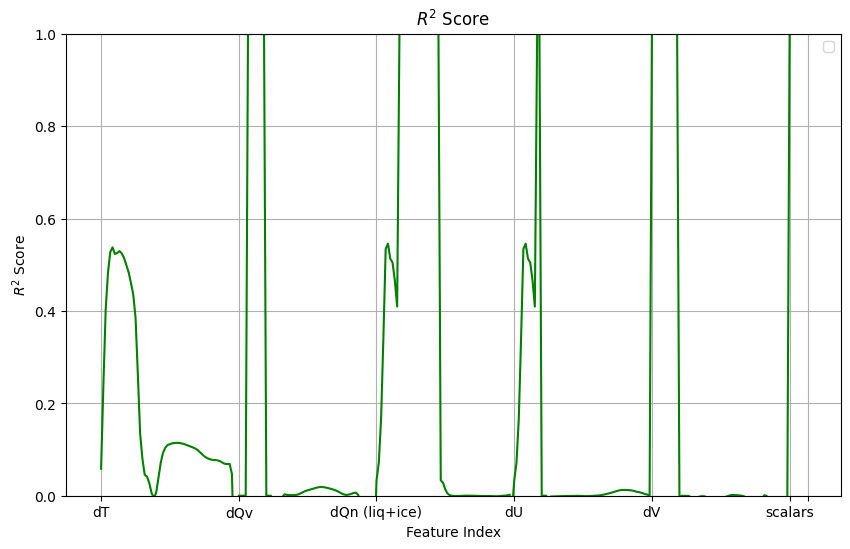

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(data.target_feature_len), joint_r2_scores, color = 'green')
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(0, 1)
plt.grid(True)

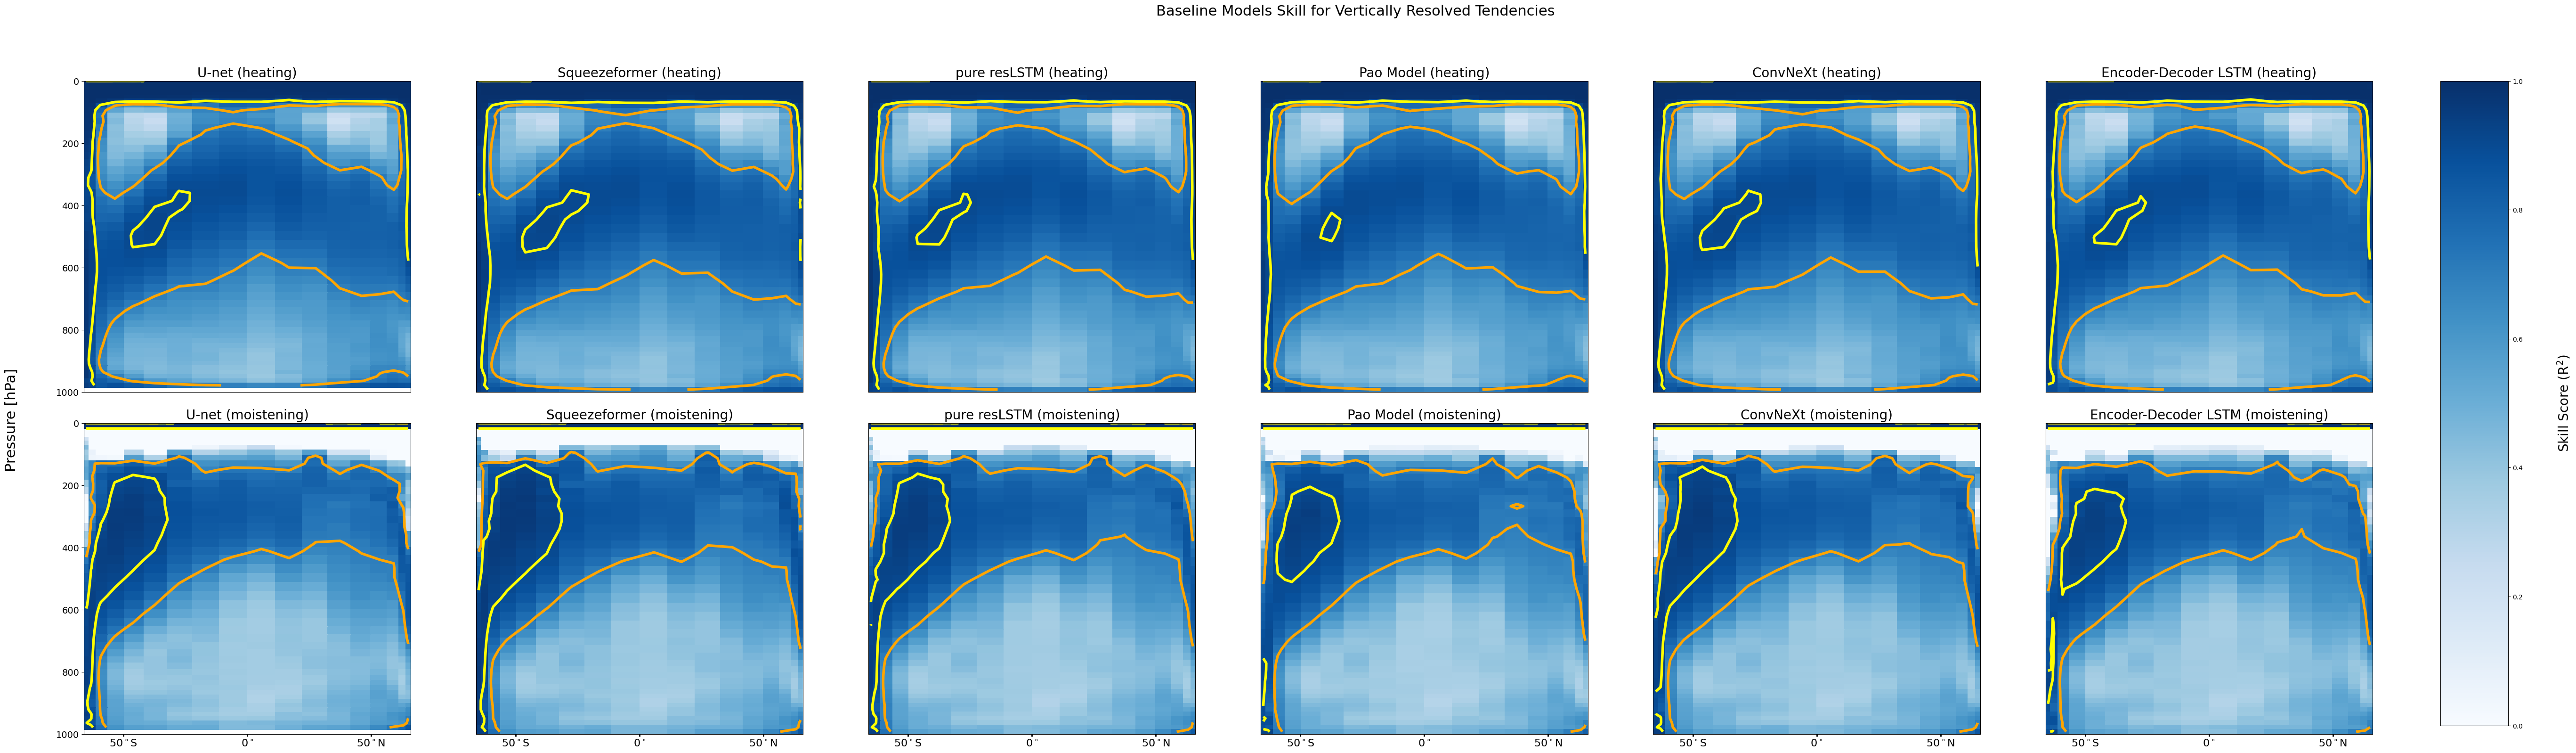

In [6]:
fig, ax = plt.subplots(2, num_models, figsize = (num_models*12, 18))
y = np.arange(60)
X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
Y = (1/100) * np.mean(pressures_binned, axis = 0).T
for i, model_name in enumerate(model_paths.keys()):
    contour_plot_heating = ax[0,i].pcolor(X, Y, zonal_heating_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1)
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[0,i].set_ylim(ax[0,i].get_ylim()[::-1])
    ax[0,i].set_title(f'{model_labels[model_name]} (heating)', fontsize = 20)
    ax[0,i].set_xticks([])
    contour_plot = ax[1,i].pcolor(X, Y, zonal_moistening_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[1,i].set_ylim(ax[1,i].get_ylim()[::-1])
    ax[1,i].set_title(f'{model_labels[model_name]} (moistening)', fontsize = 20)
    ax[1,i].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1,i].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
    ax[1,i].xaxis.set_tick_params(width = 2)
    if i != 0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
ax[0,0].set_ylabel("Pressure [hPa]", fontsize = 22)
ax[0,0].yaxis.set_label_coords(-0.2,-0.09) # (-1.38,-0.09)
ax[0,0].yaxis.set_tick_params(labelsize = 14)
ax[1,0].yaxis.set_tick_params(labelsize = 14)
ax[0,0].yaxis.set_ticks([1000,800,600,400,200,0])
ax[1,0].yaxis.set_ticks([1000,800,600,400,200,0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
cb = fig.colorbar(contour_plot, cax=cbar_ax)
cb.set_label("Skill Score "+r'$\left(\mathrm{R^{2}}\right)$',labelpad=50.1, fontsize = 20)
plt.suptitle("Baseline Models Skill for Vertically Resolved Tendencies", y = 0.97, fontsize = 22)
plt.subplots_adjust(hspace=0.1)

/tmp/ipykernel_114167/3368918310.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_cmap = cm.get_cmap('seismic').reversed()


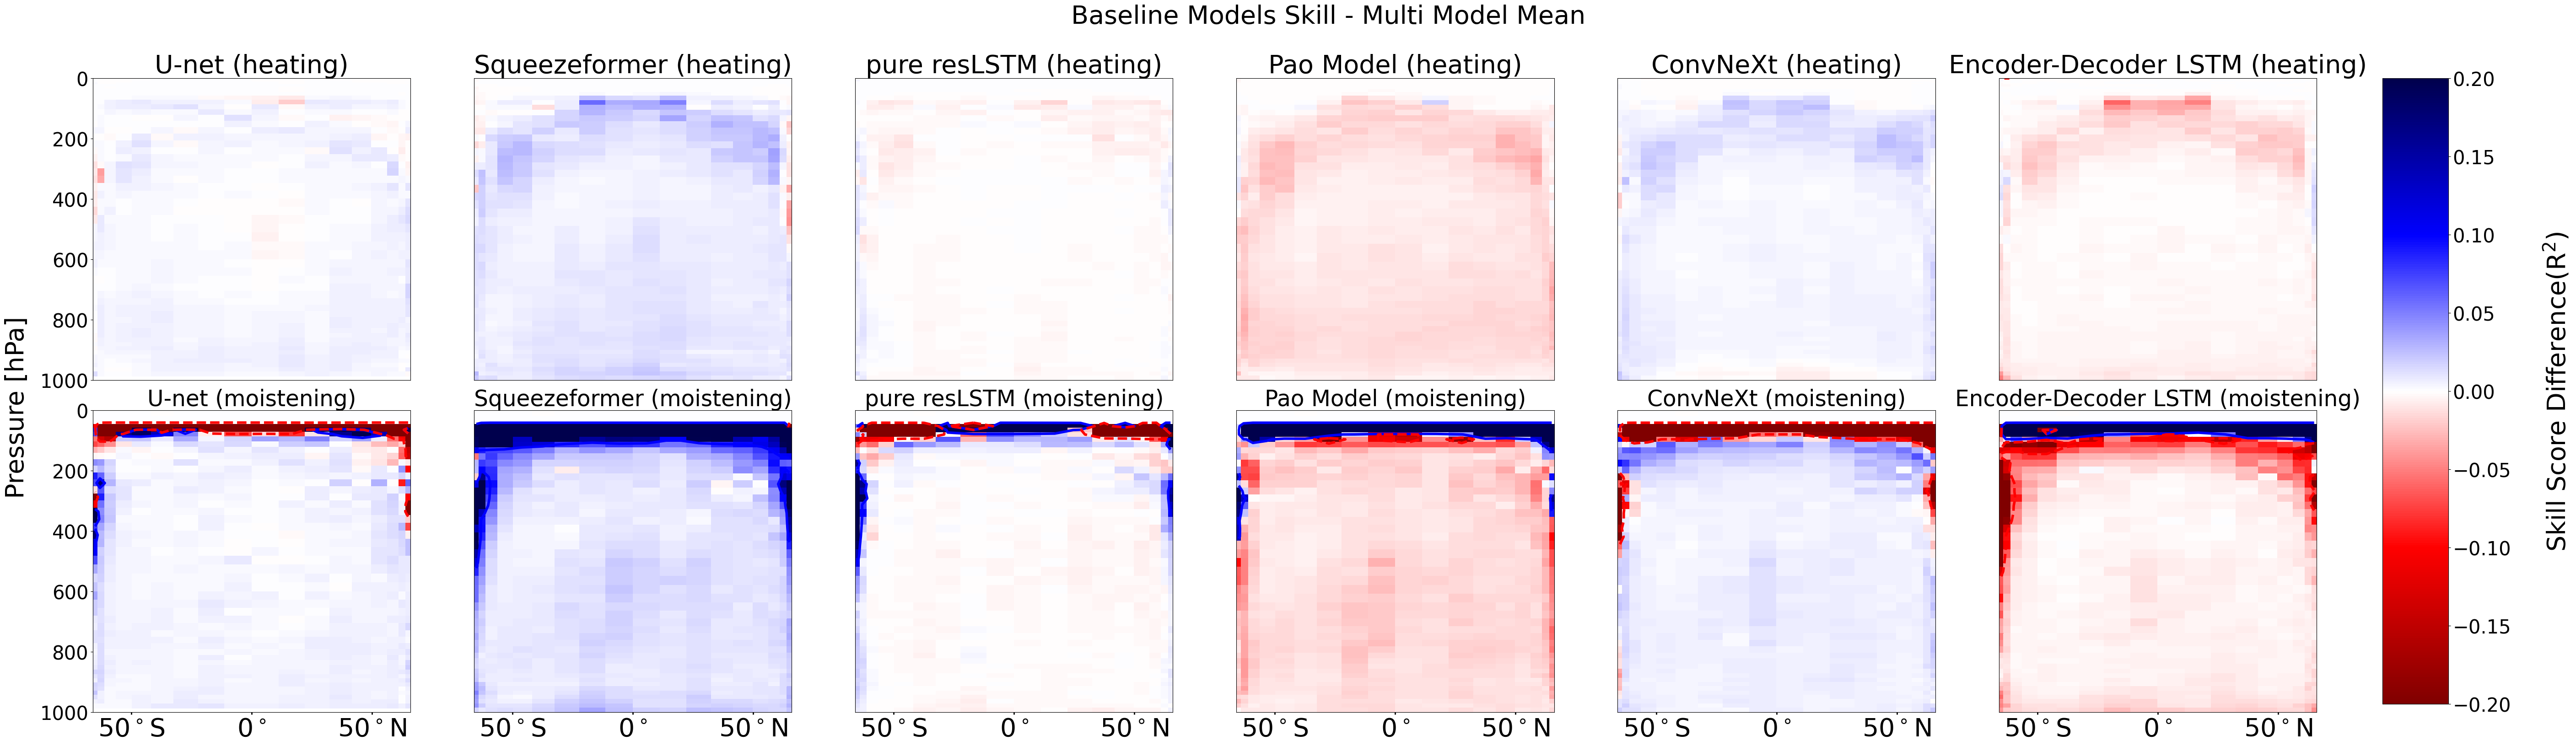

In [18]:
fig, ax = plt.subplots(2, num_models, figsize = (num_models*12, 18))
y = np.arange(60)
X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
Y = (1/100) * np.mean(pressures_binned, axis = 0).T
reversed_cmap = cm.get_cmap('seismic').reversed()
for i, model_name in enumerate(model_paths.keys()):
    zonal_heating_r2_diff = (zonal_heating_r2[model_name] - zonal_heating_r2_avg).T
    zonal_moistening_r2_diff = (zonal_moistening_r2[model_name] - zonal_moistening_r2_avg).T
    contour_plot_heating = ax[0,i].pcolor(X, Y, zonal_heating_r2_diff, cmap=reversed_cmap, vmin = -.2, vmax = .2)
    ax[0,i].contour(X, Y, zonal_heating_r2_diff, [0.1], colors='blue', linewidths=[4])
    ax[0,i].contour(X, Y, zonal_heating_r2_diff, [-0.1], colors='red', linewidths=[4])
    ax[0,i].set_ylim(ax[0,i].get_ylim()[::-1])
    ax[0,i].set_title(f'{model_labels[model_name]} (heating)', fontsize = 40)
    ax[0,i].set_xticks([])
    contour_plot = ax[1,i].pcolor(X, Y, zonal_moistening_r2_diff, cmap=reversed_cmap, vmin = -.2, vmax = .2) # pcolormesh
    ax[1,i].contour(X, Y, zonal_moistening_r2_diff, [0.1], colors='blue', linewidths=[4])
    ax[1,i].contour(X, Y, zonal_moistening_r2_diff, [-0.1], colors='red', linewidths=[4])
    ax[1,i].set_ylim(ax[1,i].get_ylim()[::-1])
    ax[1,i].set_title(f'{model_labels[model_name]} (moistening)', fontsize = 35)
    ax[1,i].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1,i].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 40)
    ax[1,i].xaxis.set_tick_params(width = 2)
    if i != 0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
ax[0,0].set_ylabel("Pressure [hPa]", fontsize = 40)
ax[0,0].yaxis.set_label_coords(-0.2,-0.09) # (-1.38,-0.09)
ax[0,0].yaxis.set_tick_params(labelsize = 30)
ax[1,0].yaxis.set_tick_params(labelsize = 30)
ax[0,0].yaxis.set_ticks([1000,800,600,400,200,0])
ax[1,0].yaxis.set_ticks([1000,800,600,400,200,0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
cbar_ax.tick_params(labelsize=30)
cb = fig.colorbar(contour_plot, cax=cbar_ax)
cb.set_label("Skill Score Difference"+r'$\left(\mathrm{R^{2}}\right)$',labelpad=50.1, fontsize = 40)
plt.suptitle("Baseline Models Skill - Multi Model Mean", y = 0.97, fontsize = 40)
plt.subplots_adjust(hspace=0.1)